#### Set up

In [1]:
!pip install catboost
!pip install xgboost
!pip install lightgbm
!pip install yahoo_fin

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.1/81.1 kB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.5/50.5 kB 5.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.4/83.4 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 kB 13.7 MB/s eta 0:00:00
  Created wheel for bs4: filename=bs4-0.0.1-py3-none-any.whl size=1257 sha256=47d6f5d921c9ea79bc3a5b071c9227459755f9edfd828788ac781faac397b5a8
  Stored in directory: /root/.cache/pip/wheels/25/42/45/b773edc52acb16cd2db4cf1a0b47117e2f69bb4eb300ed0e70
  Created wheel for sgmllib3k: filename=sgmllib3k-1.0.0-py3-none-any.whl size=6046 sha256=c52c2aa0992259ea19fd6dc6fd1cd7ab7b6eeb3c236109399a798693e9ed7b2a
  Stored in directory: /root/.cache/pip/wheels/f0/69/93/a47e9d621be168e9e33c7ce60524393c0b92ae83cf6c6e89c5
Succ

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from datetime import date
import math
import pandas_datareader as web

In [3]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

In [4]:
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)

#### Load Dataset

In [58]:
from yahoo_fin.stock_info import get_data

data = get_data("INFY.NS", start_date="01/01/2001", end_date="01/07/2023", index_as_date=True, interval="1d")

In [59]:
data

,open,high,low,close,adjclose,volume,ticker
2001-01-01,89.140625,90.623436,86.875000,87.400002,57.967491,59981248.0,INFY.NS
2001-01-02,87.515625,89.531250,85.937500,88.763283,58.871674,68767872.0,INFY.NS
2001-01-03,87.500000,88.281250,85.682816,87.723434,58.181995,64125952.0,INFY.NS
2001-01-04,87.968750,96.718750,87.968750,95.333595,63.229401,71192960.0,INFY.NS
2001-01-05,95.296875,99.984375,94.656250,99.709373,66.131607,67941888.0,INFY.NS
...,...,...,...,...,...,...,...
2023-01-02,1514.000000,1526.500000,1504.050049,1524.000000,1483.825439,3801140.0,INFY.NS
2023-01-03,1519.849976,1532.650024,1515.099976,1522.550049,1482.413818,4551130.0,INFY.NS
2023-01-04,1521.000000,1521.000000,1491.099976,1494.800049,1455.395264,7059590.0,INFY.NS
2023-01-05,1505.900024,1505.900024,1469.250000,1475.199951,1436.311890,9868404.0,INFY.NS


#### EDA


In [ ]:
print('There are {} number of days in the dataset.'.format(data.shape[0]))

There are 5627 number of days in the dataset.


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5627 entries, 2001-01-01 to 2023-07-14
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   open      5620 non-null   float64
 1   high      5620 non-null   float64
 2   low       5620 non-null   float64
 3   close     5620 non-null   float64
 4   adjclose  5620 non-null   float64
 5   volume    5620 non-null   float64
 6   ticker    5627 non-null   object 
dtypes: float64(6), object(1)
memory usage: 351.7+ KB


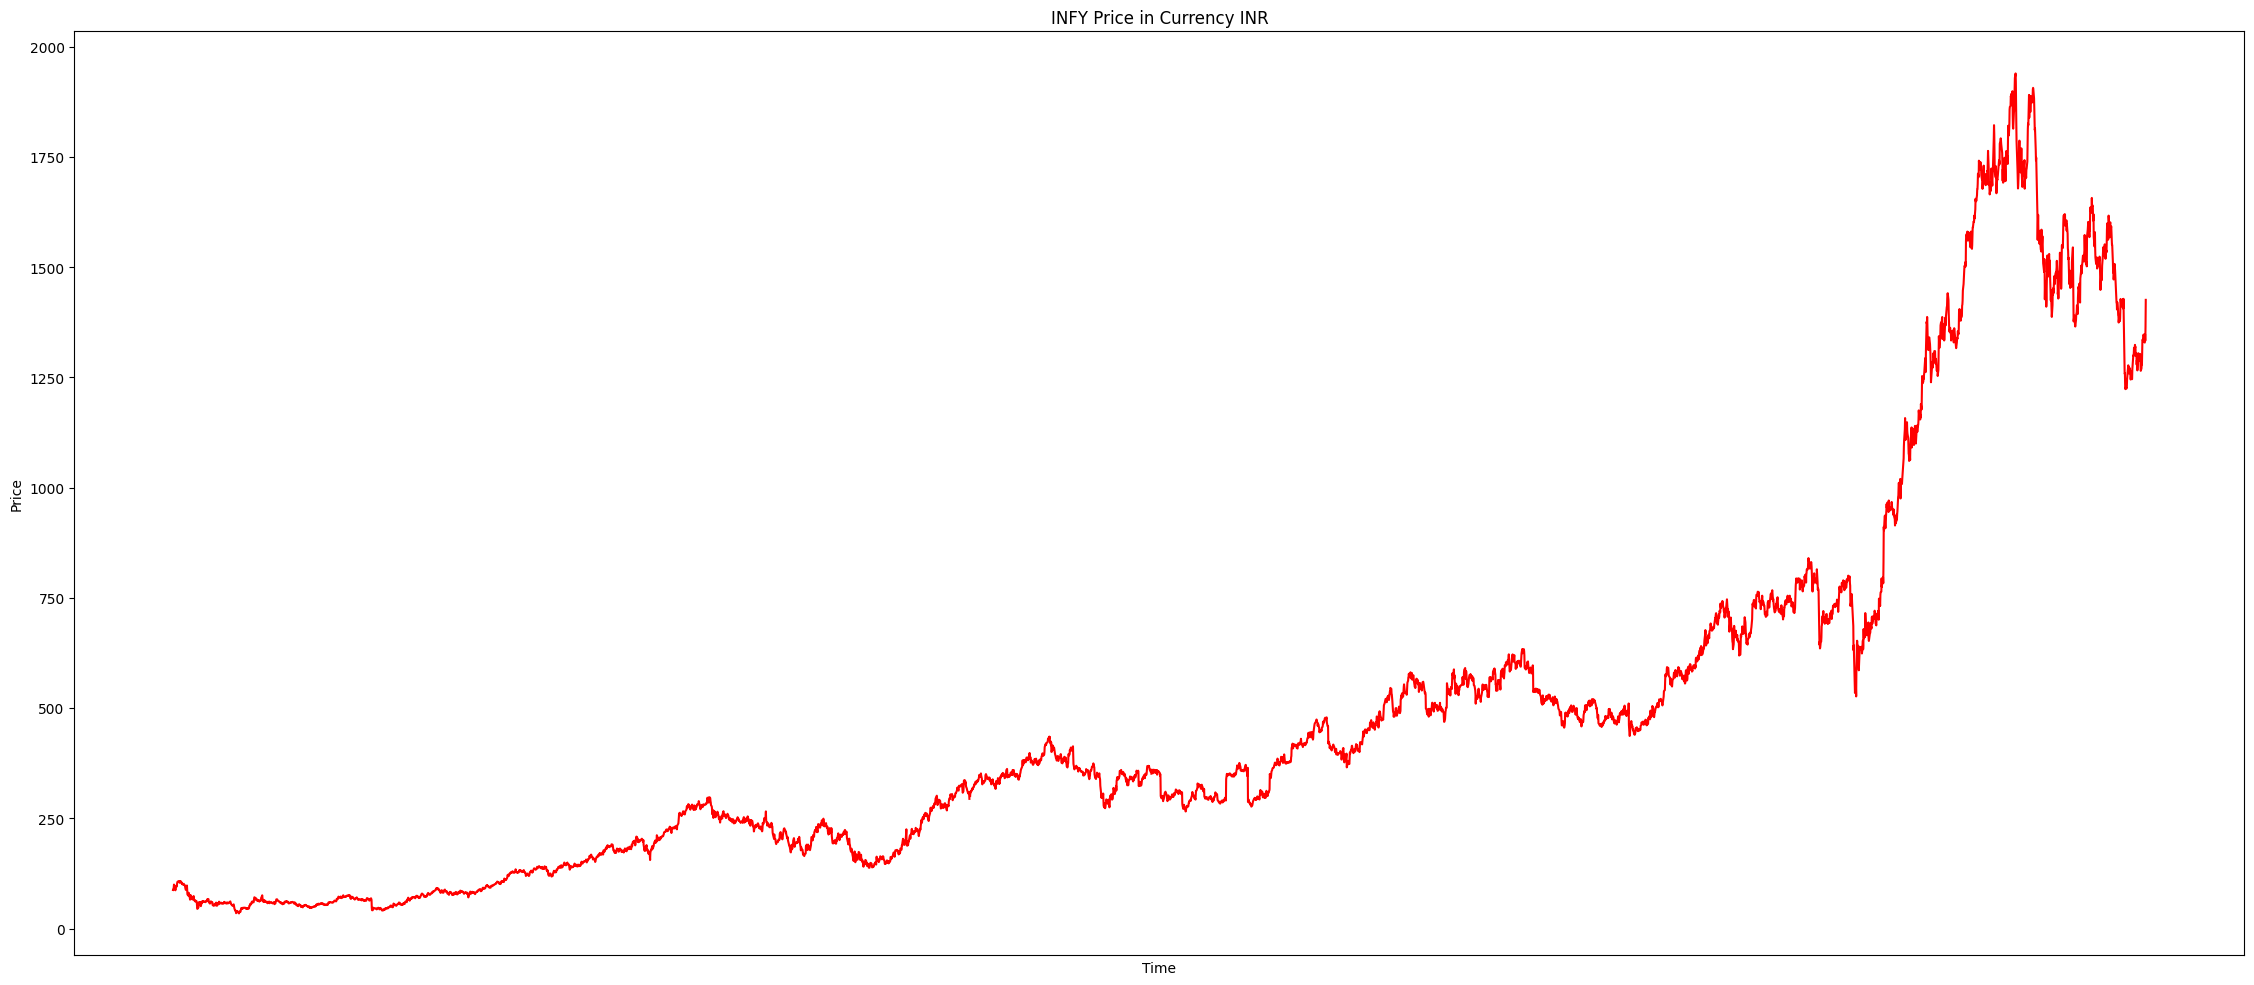

In [ ]:
plt.figure(figsize=(28,12))
plt.plot(data.close, color = 'red')
plt.xticks([])
plt.title('INFY Price in Currency INR')
plt.xlabel('Time')
plt.ylabel('Price')
plt.savefig('image.png')


plt.show()


#### Processing

In [60]:
def relative_strength_idx(df, n=14):
    close = df['close']
    delta = close.diff()
    delta = delta[1:]
    pricesUp = delta.copy()
    pricesDown = delta.copy()
    pricesUp[pricesUp < 0] = 0
    pricesDown[pricesDown > 0] = 0
    rollUp = pricesUp.rolling(n).mean()
    rollDown = pricesDown.abs().rolling(n).mean()
    rs = rollUp / rollDown
    rsi = 100.0 - (100.0 / (1.0 + rs))
    return rsi



def get_technical_indicators(dataset):
    # Create 7 and 21 days Moving Average
    dataset['EMA_9'] = dataset['close'].ewm(9).mean().shift()
    dataset['SMA_5'] = dataset['close'].rolling(5).mean().shift()
    dataset['SMA_10'] = dataset['close'].rolling(10).mean().shift()
    dataset['SMA_15'] = dataset['close'].rolling(15).mean().shift()
    dataset['SMA_30'] = dataset['close'].rolling(30).mean().shift()

    dataset['RSI'] = relative_strength_idx(dataset).fillna(0)

    EMA_12 = pd.Series(dataset['close'].ewm(span=12, min_periods=12).mean())
    EMA_26 = pd.Series(dataset['close'].ewm(span=26, min_periods=26).mean())
    dataset['MACD'] = pd.Series(EMA_12 - EMA_26)
    dataset['MACD_signal'] = pd.Series(dataset.MACD.ewm(span=9, min_periods=9).mean())

    dataset['close'] = dataset['close'].shift(-1)

    dataset = dataset.iloc[33:] # Because of moving averages and MACD line
    dataset = dataset[:-1]      # Because of shifting close price
    dataset['date'] = dataset.index
    dataset.index = range(len(dataset))

    dataset.drop(['open',	'high',	'low',	'adjclose',	'volume',	'ticker'], axis=1, inplace=True)

    final = dataset[['date']].copy()
    final['value'] = dataset['close']
    final['type'] = "Close"

    for i in ['EMA_9',	'SMA_5',	'SMA_10',	'SMA_15',	'SMA_30',	'RSI',	'MACD',	'MACD_signal']:
        temp = dataset[['date']].copy()
        temp['value'] = dataset[i]
        temp['type'] = i
        final = pd.concat([final, temp], ignore_index=True)
    return final



In [62]:
data1 = get_technical_indicators(data)

In [9]:
data.reset_index(inplace=True)
data = data[['close']]


In [10]:
data.tail()

,close
5495,1524.000000
5496,1522.550049
5497,1494.800049
5498,1475.199951
5499,1448.500000


In [11]:
data = data.dropna()

In [12]:
# #Dealing with rows that contain NAN
# print(data.isnull().sum())
# datasub=data.dropna()
# datasub.isnull().sum()

# #Drop redundant columns
# datasub=datasub.drop(['open','high','low','adjclose'	,'volume', 'ticker'], axis=1)
# datasub.head()

#### Training


##### Data Preparation

In [70]:
print('Total dataset has {} samples, and {} features.'.format(data.shape[0], \
                                                              data.shape[1]))

Total dataset has 5493 samples, and 1 features.


In [71]:
test_size  = 0.15

test_split_idx  = int(data.shape[0] * (1-test_size))

train_df  = data.loc[:test_split_idx].copy()
test_df   = data.loc[test_split_idx+1:].copy()

In [72]:
train_df

,close
0,87.400002
1,88.763283
2,87.723434
3,95.333595
4,99.709373
...,...
4665,802.500000
4666,806.950012
4667,814.900024
4668,814.250000


In [73]:
test_df

,close
4670,834.049988
4671,840.150024
4672,829.099976
4673,820.099976
4674,816.400024
...,...
5495,1524.000000
5496,1522.550049
5497,1494.800049
5498,1475.199951


In [74]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(train_df)

training_data_len = int(np.ceil( len(train_df)))

train_data = scaled_data[0:int(training_data_len), :]
# Split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    # if i<= 61:
    #     print(x_train)
    #     print(y_train)
    #     print()

# Convert the x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape the data
# x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))


In [75]:
scaled_test_data = scaler.fit_transform(test_df)

testing_data_len = int(np.ceil( len(test_df)))

test_data = scaled_test_data[0:int(testing_data_len), :]
# Split the data into x_train and y_train data sets
x_test = []
y_test = []

for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])
    y_test.append(test_data[i, 0])
    # if i<= 61:
    #     print(x_train)
    #     print(y_train)
    #     print()

# Convert the x_train and y_train to numpy arrays
x_test, y_test = np.array(x_test), np.array(y_test)

# Reshape the data
# x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [80]:
x_train[0], y_train[0]

(array([0.06761673, 0.06934871, 0.06802764, 0.07769597, 0.08325517,
        0.07537938, 0.07425284, 0.06905591, 0.06671848, 0.07172683,
        0.07904582, 0.07763344, 0.08159664, 0.08422587, 0.09057118,
        0.09229125, 0.09069227, 0.09213443, 0.09130864, 0.09130864,
        0.08830621, 0.09332349, 0.09142079, 0.09059996, 0.09282821,
        0.08888088, 0.08907443, 0.08553901, 0.08631914, 0.08412563,
        0.08300903, 0.08310233, 0.08299612, 0.08552214, 0.08153113,
        0.08156488, 0.08087804, 0.07388362, 0.07158887, 0.0681924 ,
        0.07020031, 0.06843359, 0.08048103, 0.0689904 , 0.05504522,
        0.05174901, 0.05174901, 0.05965359, 0.05843773, 0.05404475,
        0.04492828, 0.03979685, 0.05030585, 0.05329142, 0.04987212,
        0.04502753, 0.04325088, 0.04550196, 0.0421045 , 0.04020479]),
 0.042297058431556865)

In [77]:
x_train.shape, y_train.shape

((4603, 60), (4603,))

In [78]:
x_test.shape, y_test.shape

((770, 60), (770,))

In [79]:
from tensorflow.keras import backend as K

def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))

##### Machine Learning - Boosting

###### CatBoost

In [ ]:
import catboost as cb

cbreg = cb.CatBoostRegressor()


# train_dataset = cb.Pool(X_train_ml, y_train_ml)
# test_dataset = cb.Pool(X_test, y_test_ml)

In [ ]:
param_grid = {'iterations': [100, 150, 200],
        'learning_rate': [0.03, 0.1],
        'depth': [2, 4, 6],
        'l2_leaf_reg': [0.2, 0.5, 1]}

# try out every combination of the above values
search_cb = GridSearchCV(cbreg, param_grid, cv=10).fit(x_train, y_train)

Streaming output truncated to the last 5000 lines.
0:	learn: 0.2344897	total: 28.3ms	remaining: 5.64s
1:	learn: 0.2122207	total: 54.8ms	remaining: 5.42s
2:	learn: 0.1922719	total: 81.4ms	remaining: 5.34s
3:	learn: 0.1743346	total: 108ms	remaining: 5.29s
4:	learn: 0.1581235	total: 133ms	remaining: 5.19s
5:	learn: 0.1433407	total: 159ms	remaining: 5.16s
6:	learn: 0.1298477	total: 188ms	remaining: 5.17s
7:	learn: 0.1179098	total: 216ms	remaining: 5.17s
8:	learn: 0.1070482	total: 246ms	remaining: 5.22s
9:	learn: 0.0973060	total: 272ms	remaining: 5.17s
10:	learn: 0.0886461	total: 298ms	remaining: 5.13s
11:	learn: 0.0808552	total: 324ms	remaining: 5.08s
12:	learn: 0.0739254	total: 350ms	remaining: 5.04s
13:	learn: 0.0677671	total: 376ms	remaining: 5s
14:	learn: 0.0620273	total: 402ms	remaining: 4.96s
15:	learn: 0.0568647	total: 427ms	remaining: 4.91s
16:	learn: 0.0523819	total: 452ms	remaining: 4.87s
17:	learn: 0.0483802	total: 481ms	remaining: 4.86s
18:	learn: 0.0448444	total: 496ms	remaini

In [ ]:
cbreg = cb.CatBoostRegressor(learning_rate = search_cb.best_params_["learning_rate"],
                        iterations       = search_cb.best_params_["iterations"],
                        depth              = search_cb.best_params_["depth"],
                        l2_leaf_reg        = search_cb.best_params_["l2_leaf_reg"])

cbreg.fit(x_train, y_train)

0:	learn: 0.2236794	total: 13.3ms	remaining: 2.65s
1:	learn: 0.2025760	total: 26.1ms	remaining: 2.59s
2:	learn: 0.1839016	total: 39.3ms	remaining: 2.58s
3:	learn: 0.1665145	total: 51.6ms	remaining: 2.53s
4:	learn: 0.1508662	total: 63.8ms	remaining: 2.49s
5:	learn: 0.1369103	total: 76.4ms	remaining: 2.47s
6:	learn: 0.1241118	total: 89.8ms	remaining: 2.47s
7:	learn: 0.1125439	total: 102ms	remaining: 2.46s
8:	learn: 0.1022858	total: 115ms	remaining: 2.44s
9:	learn: 0.0930759	total: 128ms	remaining: 2.43s
10:	learn: 0.0846581	total: 141ms	remaining: 2.42s
11:	learn: 0.0771920	total: 153ms	remaining: 2.39s
12:	learn: 0.0706638	total: 172ms	remaining: 2.48s
13:	learn: 0.0647437	total: 185ms	remaining: 2.45s
14:	learn: 0.0593857	total: 197ms	remaining: 2.42s
15:	learn: 0.0543093	total: 210ms	remaining: 2.42s
16:	learn: 0.0501134	total: 227ms	remaining: 2.44s
17:	learn: 0.0463697	total: 250ms	remaining: 2.53s
18:	learn: 0.0430600	total: 262ms	remaining: 2.5s
19:	learn: 0.0401018	total: 275ms	r

In [ ]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

y_pred_cb = cbreg.predict(x_test)
rmse = (np.sqrt(mean_squared_error(y_test, y_pred_cb)))
r2 = r2_score(y_test, y_pred_cb)

In [ ]:
y_pred_cb.shape

(770,)

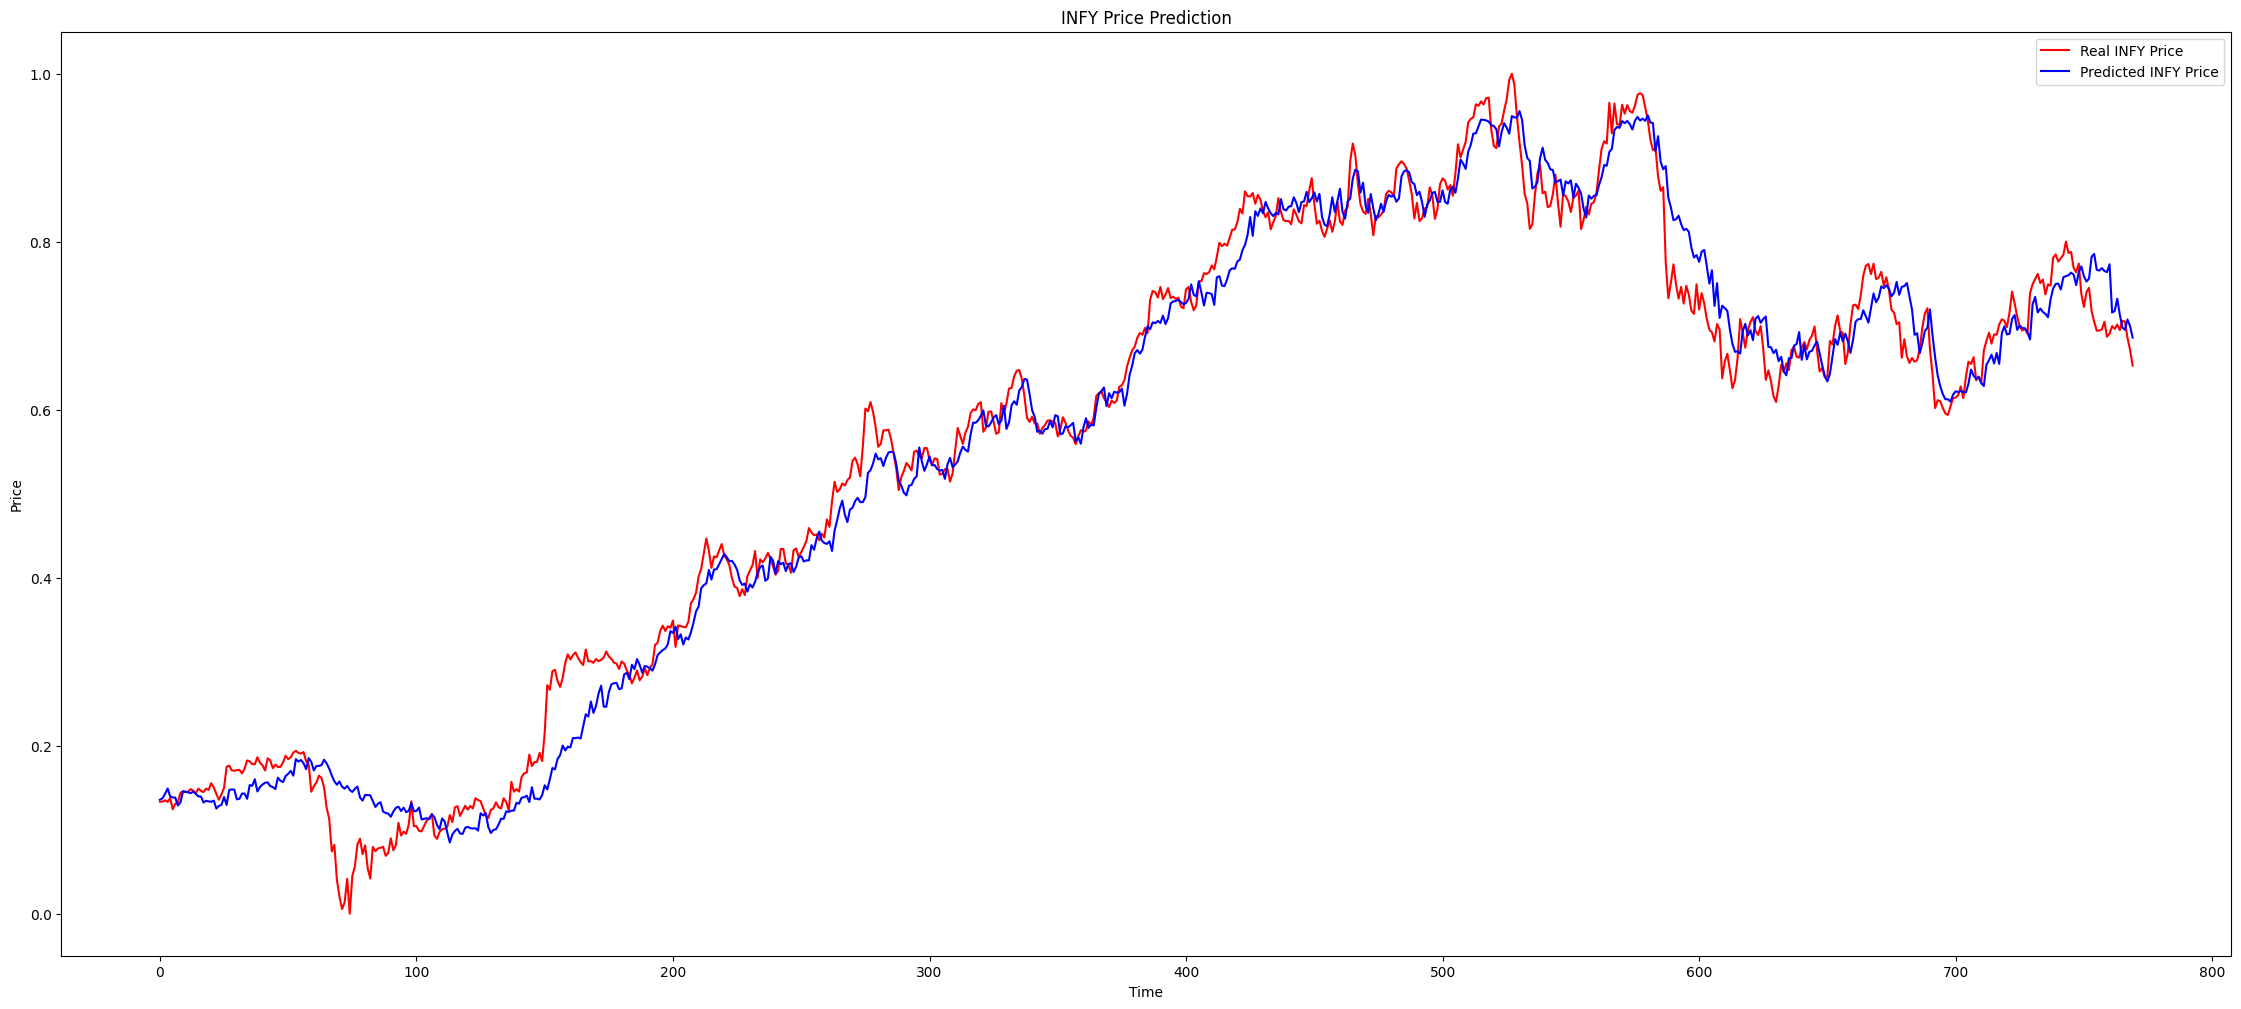

In [ ]:
plt.figure(figsize=(28,12))
plt.plot(np.array(y_test), color = 'red', label = 'Real INFY Price')
plt.plot(y_pred_cb, color = 'blue', label = 'Predicted INFY Price')
plt.title('INFY Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()

plt.savefig('prediction_catboost.png')
plt.show()

In [ ]:
rmse, r2

(0.03681117286574126, 0.9811070210945103)

In [ ]:
cbreg.save_model("catboost.cbm")

In [ ]:
search_cb.best_params_

{'depth': 6, 'iterations': 200, 'l2_leaf_reg': 0.2, 'learning_rate': 0.1}

###### XGBoost

In [ ]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import cross_validate, validation_curve, learning_curve, GridSearchCV


RANDOM_STATE = 7777
def myRMSE(y_pred, y_real):
  return np.sqrt(mean_squared_error(y_real, y_pred))

RMSE_score = make_scorer(myRMSE, greater_is_better=False)

In [ ]:

param_tuning = {
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 5, 7, 10],
        'min_child_weight': [1, 3, 5],
        'subsample': [0.5, 0.7],
        'colsample_bytree': [0.5, 0.7],
        'n_estimators' : [100, 200, 500],
        'objective': ['reg:squarederror']
    }

xgb_model = xgb.XGBRegressor()

xgb_search = GridSearchCV(estimator = xgb_model,
                        param_grid = param_tuning,
                        #scoring = 'neg_mean_absolute_error', #MAE
                        scoring = RMSE_score,
                        cv = 5,
                        n_jobs = -1,
                        verbose = 1)

xgb_search.fit(x_train,y_train)


Fitting 5 folds for each of 288 candidates, totalling 1440 fits


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.5, 0.7],
                         'learning_rate': [0.01, 0.1],
                         'max_depth': [3, 5, 7, 10],
                         'min_child_weight': [1, 3, 5],
                         'n_estimators': [100, 200, 500],
                         'objective': ['reg:squarederror'],
                         'subsample': [0.5, 0.7]},
             scoring=make_scorer(myRMSE, greater_is_better=False), verbose=1)

In [ ]:
xgbreg = xgb.XGBRegressor(learning_rate = xgb_search.best_params_["learning_rate"],
                        max_depth       = xgb_search.best_params_["max_depth"],
                        min_child_weight              = xgb_search.best_params_["min_child_weight"],
                        subsample        = xgb_search.best_params_["subsample"],
                        colsample_bytree        = xgb_search.best_params_["colsample_bytree"],
                        n_estimators        = xgb_search.best_params_["n_estimators"])

xgbreg.fit(x_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=5, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [ ]:
y_pred_xgb = xgbreg.predict(x_test)
rmse_xgb = (np.sqrt(mean_squared_error(y_test, y_pred_xgb)))
r2_xgb = r2_score(y_test, y_pred_xgb)

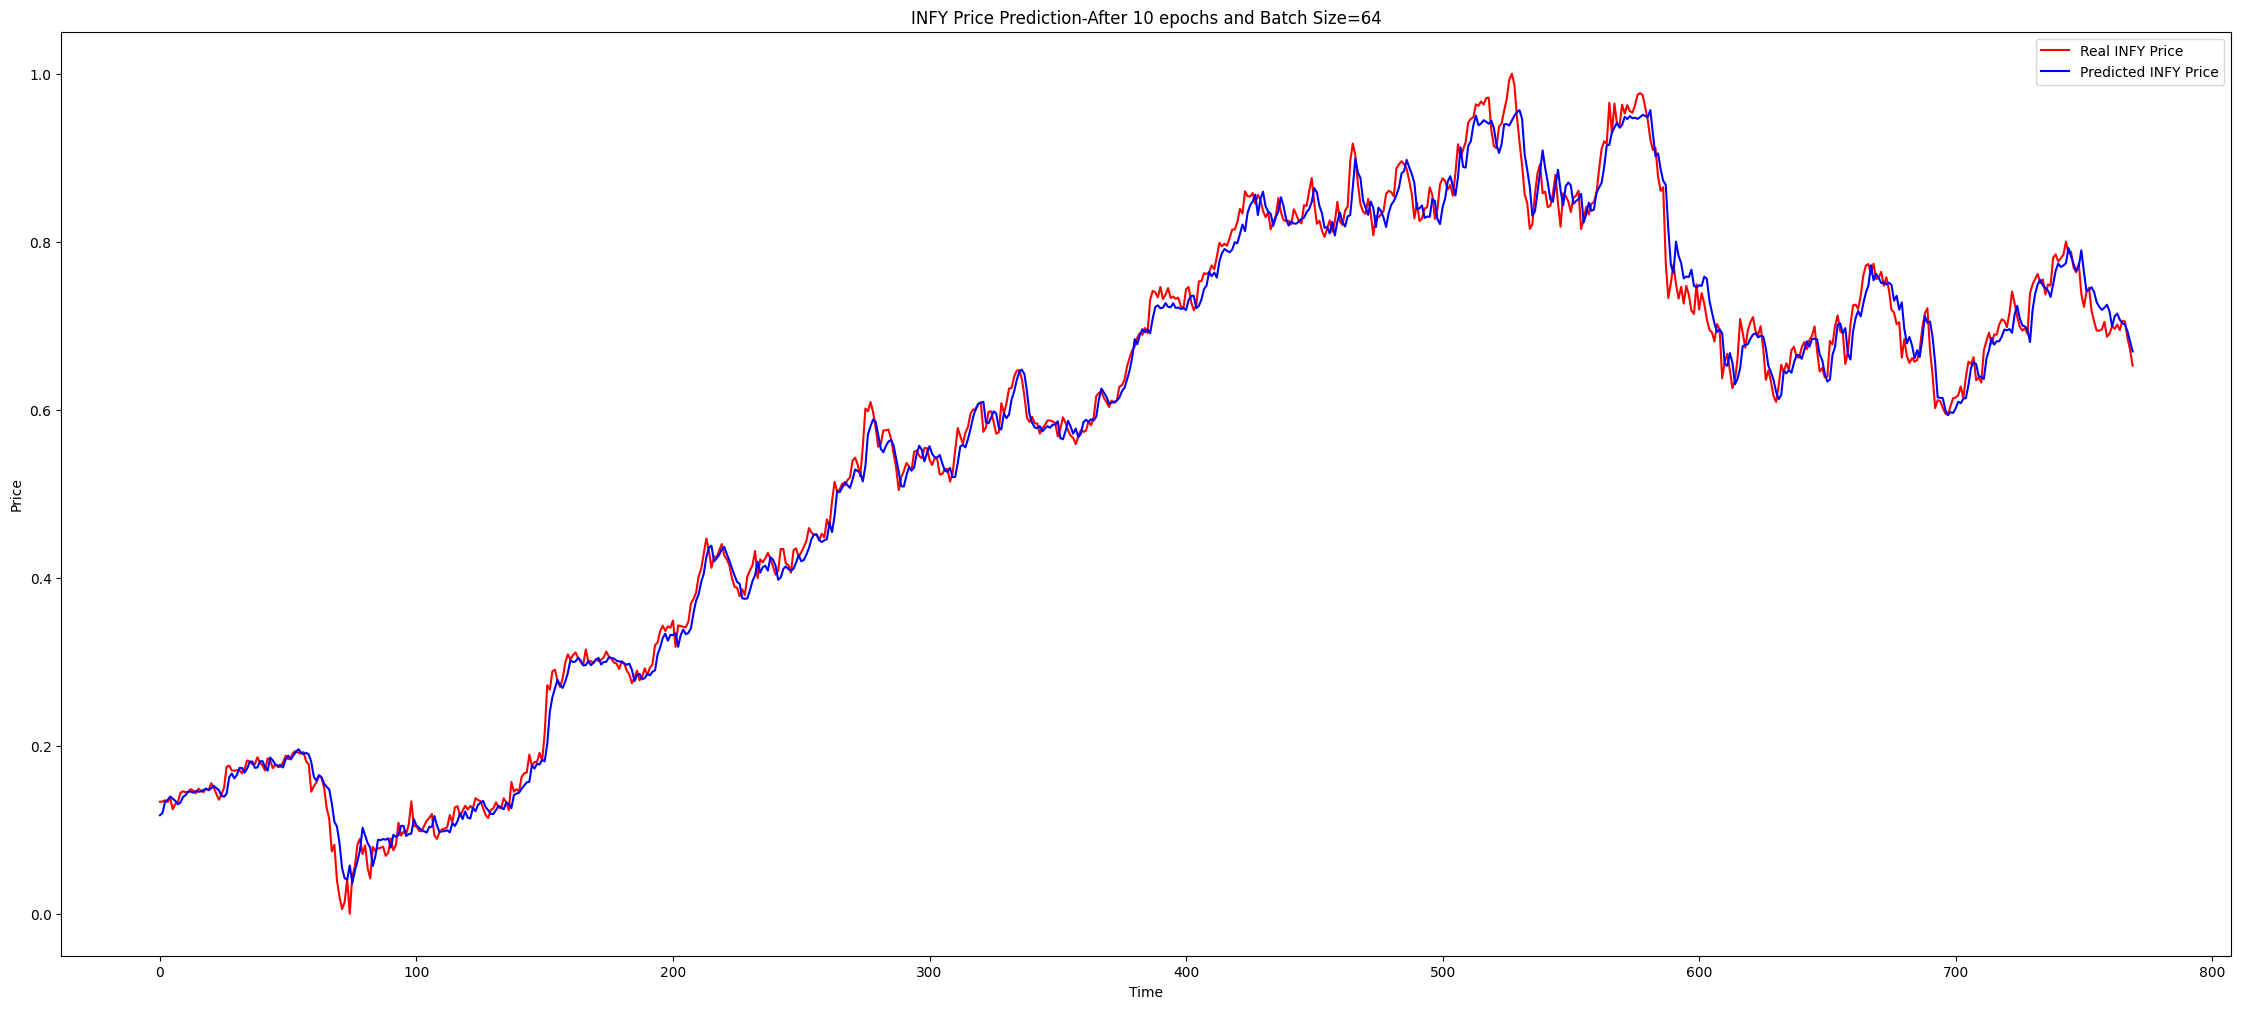

In [ ]:
plt.figure(figsize=(28,12))
plt.plot(np.array(y_test), color = 'red', label = 'Real INFY Price')
plt.plot(y_pred_xgb, color = 'blue', label = 'Predicted INFY Price')
plt.title('INFY Price Prediction-After 10 epochs and Batch Size=64')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()

plt.savefig('prediction_xgb.png')
plt.show()

In [ ]:
rmse_xgb, r2_xgb

(0.02016895867010756, 0.9943283675102682)

In [ ]:
xgbreg.save_model("xgb.json")

In [ ]:
xgb_search.best_params_

{'colsample_bytree': 0.7,
 'learning_rate': 0.1,
 'max_depth': 5,
 'min_child_weight': 5,
 'n_estimators': 500,
 'objective': 'reg:squarederror',
 'subsample': 0.7}

###### LightGBM

In [50]:
from lightgbm import LGBMRegressor

In [51]:
param_grid = {
    'learning_rate': [0.1, 0.01],
    'n_estimators': [50, 100, 150],
    'max_depth': [4, 6],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'subsample': [0.7, 0.8, 0.9],
    'min_child_samples': [1, 5, 10]
}

# Step 2: Initialize LGBMRegressor estimattor
lgbmreg = LGBMRegressor(objective='regression',
                              random_state=101)

# Step 3: Initalise Grid Search with 3-fold cross validation and fit model
search_lgbm = GridSearchCV(estimator=lgbmreg,
                     param_grid=param_grid,
                     cv=10,
                     n_jobs=-1,
                     scoring='neg_root_mean_squared_error').fit(x_train, y_train)

In [52]:
lgbmreg = LGBMRegressor(learning_rate        = search_lgbm.best_params_["learning_rate"],
                        n_estimators         = search_lgbm.best_params_["n_estimators"],
                        max_depth            = search_lgbm.best_params_["max_depth"],
                        colsample_bytree     = search_lgbm.best_params_["colsample_bytree"],
                        subsample            = search_lgbm.best_params_["subsample"],
                        min_child_samples    = search_lgbm.best_params_["min_child_samples"],
                        eval_metric='rmse')

lgbmreg.fit(x_train, y_train)

LGBMRegressor(colsample_bytree=0.8, eval_metric='rmse', max_depth=4,
              min_child_samples=10, subsample=0.7)

In [53]:
y_pred_lgbm = lgbmreg.predict(x_test)
rmse_lgbm = (np.sqrt(mean_squared_error(y_test, y_pred_lgbm)))
r2_lgbm = r2_score(y_test, y_pred_lgbm)

NameError: ignored

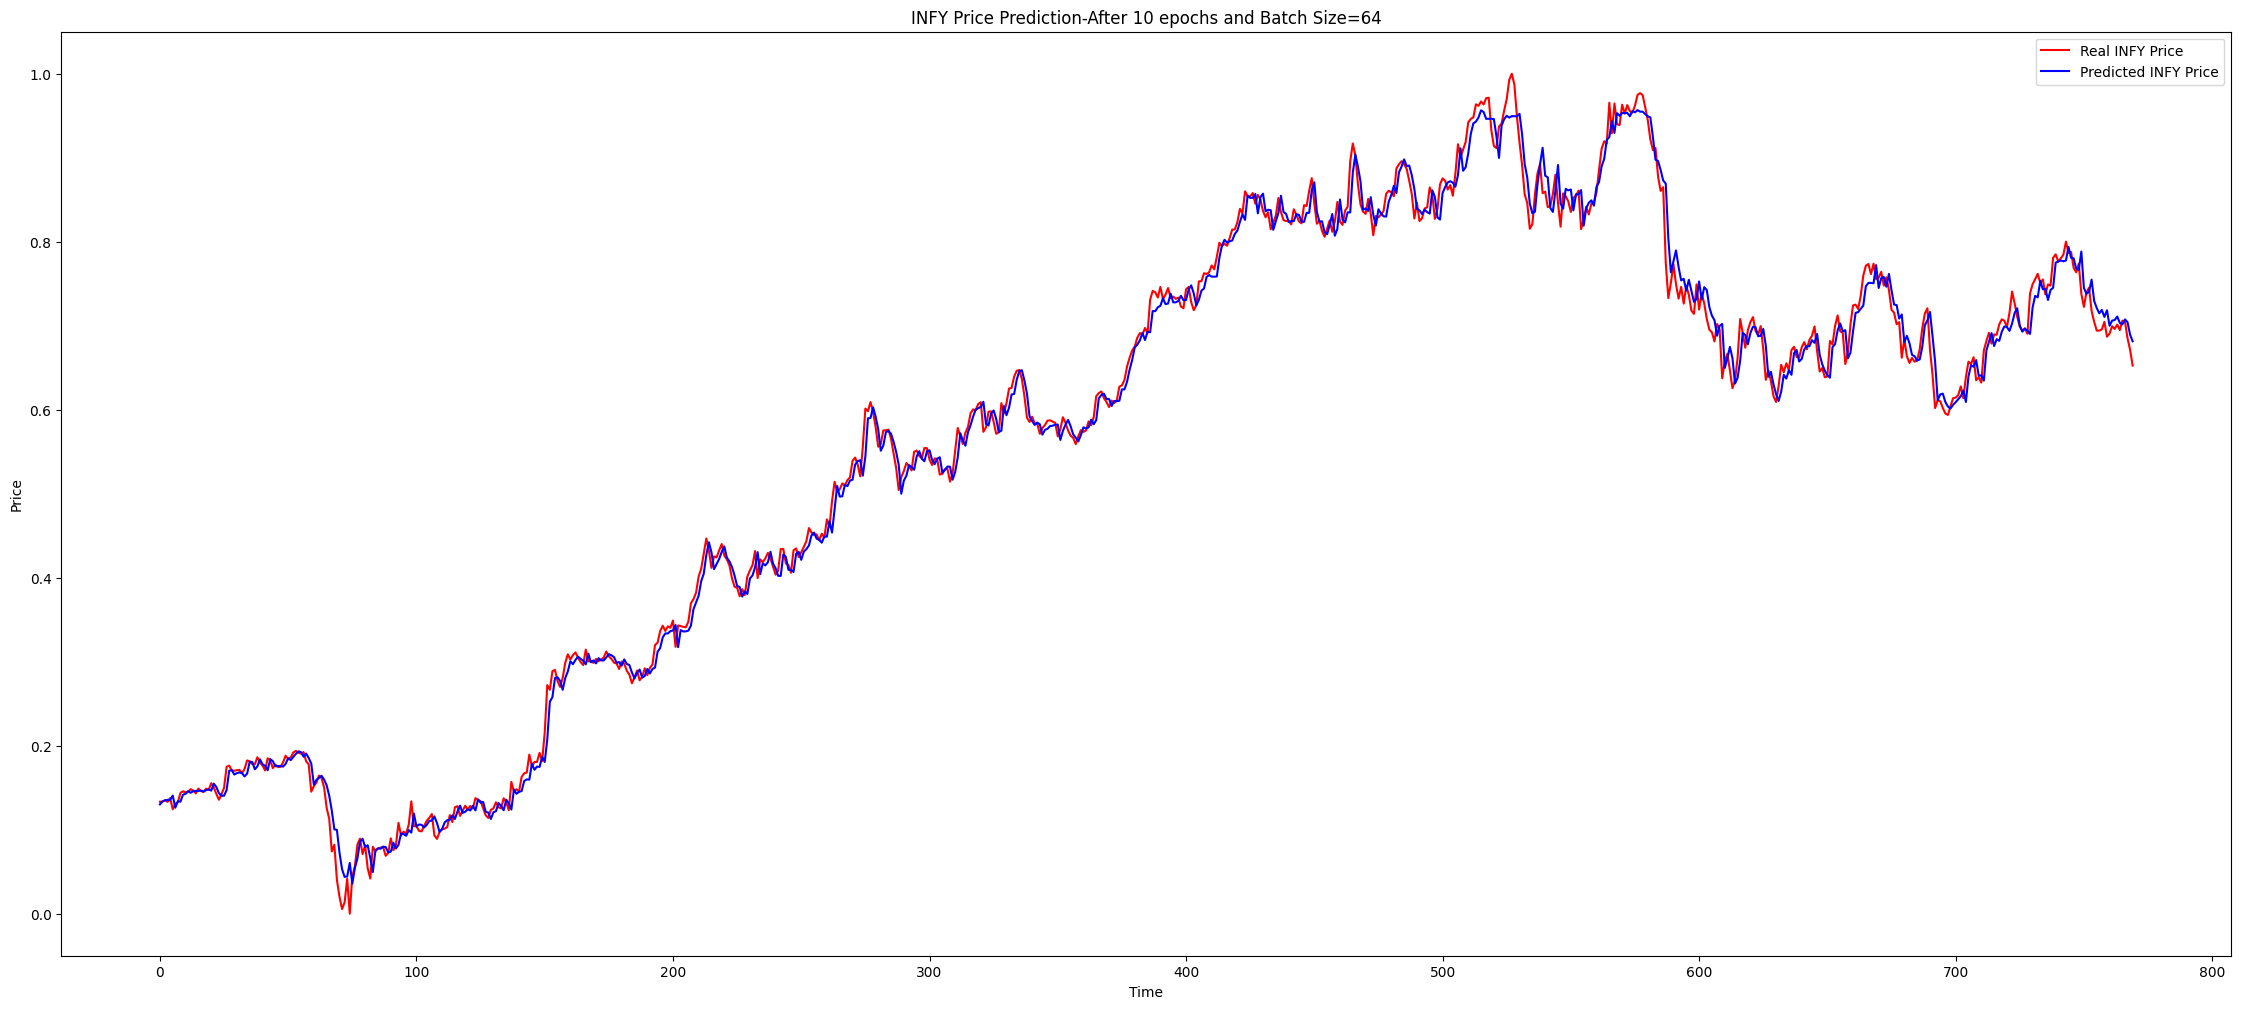

In [54]:
plt.figure(figsize=(28,12))
plt.plot(y_test, color = 'red', label = 'Real INFY Price')
plt.plot(y_pred_lgbm, color = 'blue', label = 'Predicted INFY Price')
plt.title('INFY Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()

plt.savefig('prediction_lgbm.png')
plt.show()

In [55]:
rmse_lgbm, r2_lgbm

NameError: ignored

In [56]:
search_lgbm.best_params_

{'colsample_bytree': 0.8,
 'learning_rate': 0.1,
 'max_depth': 4,
 'min_child_samples': 10,
 'n_estimators': 100,
 'subsample': 0.7}

In [57]:
lgbmreg.booster_.save_model("lgbm.txt")

##### Deep Learning - RNN

In [22]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(train_df)

training_data_len = int(np.ceil( len(train_df)))

train_data = scaled_data[0:int(training_data_len), :]
# Split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    if i<= 61:
        print(x_train)
        print(y_train)
        print()

# Convert the x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

[array([0.06761673, 0.06934871, 0.06802764, 0.07769597, 0.08325517,
       0.07537938, 0.07425284, 0.06905591, 0.06671848, 0.07172683,
       0.07904582, 0.07763344, 0.08159664, 0.08422587, 0.09057118,
       0.09229125, 0.09069227, 0.09213443, 0.09130864, 0.09130864,
       0.08830621, 0.09332349, 0.09142079, 0.09059996, 0.09282821,
       0.08888088, 0.08907443, 0.08553901, 0.08631914, 0.08412563,
       0.08300903, 0.08310233, 0.08299612, 0.08552214, 0.08153113,
       0.08156488, 0.08087804, 0.07388362, 0.07158887, 0.0681924 ,
       0.07020031, 0.06843359, 0.08048103, 0.0689904 , 0.05504522,
       0.05174901, 0.05174901, 0.05965359, 0.05843773, 0.05404475,
       0.04492828, 0.03979685, 0.05030585, 0.05329142, 0.04987212,
       0.04502753, 0.04325088, 0.04550196, 0.0421045 , 0.04020479])]
[0.042297058431556865]

[array([0.06761673, 0.06934871, 0.06802764, 0.07769597, 0.08325517,
       0.07537938, 0.07425284, 0.06905591, 0.06671848, 0.07172683,
       0.07904582, 0.07763344, 0.0

In [23]:
scaled_test_data = scaler.fit_transform(test_df)

testing_data_len = int(np.ceil( len(test_df)))

test_data = scaled_test_data[0:int(testing_data_len), :]
# Split the data into x_train and y_train data sets
x_test = []
y_test = []

for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])
    y_test.append(test_data[i, 0])
    # if i<= 61:
    #     print(x_train)
    #     print(y_train)
    #     print()

# Convert the x_train and y_train to numpy arrays
x_test, y_test = np.array(x_test), np.array(y_test)

# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [24]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((4603, 60, 1), (4603,), (770, 60, 1), (770,))

###### LSTM

In [25]:
regressor_lstm = Sequential()

regressor_lstm.add(LSTM(units = 50, activation = 'relu', return_sequences = True, input_shape = (x_train.shape[1], x_train.shape[2])))
regressor_lstm.add(Dropout(0.2))

regressor_lstm.add(LSTM(units = 60, activation = 'relu', return_sequences = True))
regressor_lstm.add(Dropout(0.3))

regressor_lstm.add(LSTM(units = 80, activation = 'relu', return_sequences = True))
regressor_lstm.add(Dropout(0.4))

regressor_lstm.add(LSTM(units = 120, activation = 'relu'))
regressor_lstm.add(Dropout(0.5))

regressor_lstm.add(Dense(units = 1))

In [26]:
regressor_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 50)            10400     
                                                                 
 dropout (Dropout)           (None, 60, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 60, 60)            26640     
                                                                 
 dropout_1 (Dropout)         (None, 60, 60)            0         
                                                                 
 lstm_2 (LSTM)               (None, 60, 80)            45120     
                                                                 
 dropout_2 (Dropout)         (None, 60, 80)            0         
                                                                 
 lstm_3 (LSTM)               (None, 120)               9

In [27]:
# Compiling the RNN
regressor_lstm.compile(optimizer = 'adam', loss = root_mean_squared_error)

In [28]:
regressor_lstm.fit(x_train, y_train, epochs=10, batch_size = 64)

Epoch 1/10


KeyboardInterrupt: ignored

In [ ]:
y_pred_lstm = regressor_lstm.predict(x_test)

In [ ]:
scale = 1/scaler.scale_[0]

In [ ]:
y_pred_lstm = y_pred_lstm*scale
y_test_rnn_lstm = y_test*scale

In [ ]:
# Visualising the results
plt.figure(figsize=(28,12))
plt.plot(y_test_rnn_lstm, color = 'red', label = 'Real INFY Price')
plt.plot(y_pred_lstm, color = 'blue', label = 'Predicted INFY Price')
plt.title('INFY Price Prediction using LSTM')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()

plt.savefig('prediction_lstm.png')
plt.show()


In [ ]:
regressor_lstm.save("lstm.h5", save_format='h5')

###### GRU


In [ ]:
from keras.layers import Dense, Dropout, LSTM, GRU, Bidirectional

In [ ]:
# The GRU architecture
regressorGRU = Sequential()
# First GRU layer with Dropout regularisation
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Second GRU layer
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Third GRU layer
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Fourth GRU layer
regressorGRU.add(GRU(units=50, activation='tanh'))
regressorGRU.add(Dropout(0.2))
# The output layer
regressorGRU.add(Dense(units=1))

In [ ]:
regressorGRU.summary()

In [ ]:
regressorGRU.compile(optimizer = 'adam', loss = root_mean_squared_error)

In [ ]:
# fitting the model

regressorGRU.fit(x_train, y_train, epochs=10, batch_size=150)

In [ ]:
y_pred_gru = regressorGRU.predict(x_test)

In [ ]:
scale = 1/scaler.scale_[0]

In [ ]:
y_pred_gru = y_pred_gru*scale
y_test_rnn_gru = y_test*scale

In [ ]:
# Visualising the results
plt.figure(figsize=(28,12))
plt.plot(y_test_rnn_gru, color = 'red', label = 'Real INFY Price')
plt.plot(y_pred_gru, color = 'blue', label = 'Predicted INFY Price')
plt.title('INFY Price Prediction-After 10 epochs and Batch Size=64')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()

plt.savefig('prediction_gru.png')
plt.show()


In [ ]:
regressorGRU.save("gru.h5", save_format='h5')